### **Uso de redes neurais para previsão hidrometeorológica de curto prazo**
###### O presente trabalho trata do uso de redes neurais para a previsão de curto prazo de nível de água na região serrana do Rio de Janeiro. Com os resultados obtidos neste trabalho foi possível concluir que é possível prever o nível de água do rio com boa acurácia.

#### Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.models import Sequential
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

import matplotlib.pyplot as plt
import datetime
from numpy.random import seed
from time import time

seed_number = 28
seed(seed_number)
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

#### Funções auxiliares

Foram criadas algumas funções para facilitar a execução dos experimentos.
* read_csv_dataset: Carrega o dataset de um arquivo CSV
* get_max_nse: Para retornar o valor máximo do NSE
* plot_history: Para plotar o desempenho da rede

In [2]:
data_path = 'data/'

def read_csv_dataset(source):
  df = pd.read_csv('{}/{}.csv'.format(data_path, source), parse_dates=['data_hora'])
  df = df.set_index('data_hora')
  return df

def get_max_nse(history):
    validation = history.history["val_nse"]
    ymax = max(validation)
    return "Max NSE ≈ " + "%.6f" % ymax

def get_metrics(history):
    validation_rmse = history.history["val_rmse"]
    validation_nse = history.history["val_nse"]
    return min(validation_rmse), max(validation_nse) 

def plot_history(history, title):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

  fig.suptitle(title)
 
  ax1.plot(history.history['nse'], label='train')
  ax1.plot(history.history['val_nse'], label='test')
  ax1.set_ylabel('nse')
  ax1.set_xlabel('epoch')

  ax2.plot(history.history['loss'], label='train')
  ax2.plot(history.history['val_loss'], label='test')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  
  ax1.text(
        0.97,
        0.97,
        get_max_nse(history),
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax1.transAxes,
        fontsize=18,
    )
  plt.legend()
  plt.show()

#### Carrega o dataset com os dados de estação

In [3]:
data = read_csv_dataset('data_final')

data.describe()

,chuva_Olaria,nivel_Olaria,chuva_Suspiro,nivel_Suspiro,chuva_ConselheiroPaulino,nivel_ConselheiroPaulino,chuva_VendaDasPedras,nivel_VendaDasPedras,chuva_Ypu,nivel_Ypu
count,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000,46080.000000
mean,0.050668,0.683814,0.042669,0.835646,0.055278,1.584493,0.051978,0.666643,0.049796,0.617024
std,0.431721,0.128411,0.435874,0.302345,0.514139,0.150803,0.550568,0.159374,0.439705,0.176312
min,0.000000,0.490000,0.000000,0.430000,0.000000,1.420000,0.000000,0.490000,0.000000,0.310000
25%,0.000000,0.590000,0.000000,0.640000,0.000000,1.490000,0.000000,0.560000,0.000000,0.520000
50%,0.000000,0.650000,0.000000,0.790000,0.000000,1.550000,0.000000,0.620000,0.000000,0.570000
75%,0.000000,0.740000,0.000000,0.940000,0.000000,1.630000,0.000000,0.710000,0.000000,0.660000
max,20.400000,2.180000,41.400000,4.540000,21.600000,3.500000,64.200000,2.300000,22.000000,2.550000


#### Normaliza e separa os dados de entrada e saida

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))


# Considera como entrada os dados de chuva e nivel 
# de todas as estacoes para o tempo t
x = scaler.fit_transform(data[['chuva_Olaria', 'nivel_Olaria',
          'chuva_VendaDasPedras', 'nivel_VendaDasPedras',
          'chuva_Suspiro', 'nivel_Suspiro',
          'chuva_Ypu', 'nivel_Ypu',
          'chuva_ConselheiroPaulino', 'nivel_ConselheiroPaulino']].values)

#Considera como saida os dados de nivel para a estacao de conselheiro paulino
# para o tempo t + 1
#y = x[:,1::2]
y = x[:,9]

date_split = datetime.datetime(year=2013, month=2, day=1, hour=0, minute=0)
train_index = data.loc[data.index<date_split]

i = 1

## Remove o ultimo tempo do df de x e o primeiro do df de y
in_data = x[:-i]
out_data = y[i:]

print(in_data.shape)
print(out_data.shape)

#Separa o dataset em treinamento, validacao e teste
x_train_without_test = in_data[0:train_index.shape[0],]
y_train_without_test = out_data[0:train_index.shape[0],]

x_test = in_data[train_index.shape[0]:,]
y_test = out_data[train_index.shape[0]:,]

x_train, x_val, y_train, y_val = train_test_split(x_train_without_test, y_train_without_test,
                                                  test_size=0.2, random_state=seed_number)


(46079, 10)
(46079,)


In [5]:
def nse(y_true, y_pred):
	return 1 - (K.sum((y_pred - y_true)**2)/
                         K.sum((y_true - K.mean(y_true))**2)) 

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#### Definição e treinamento da rede

In [6]:
input_dim = x_train.shape[1]

model = Sequential()

model.add(Dense(5,input_shape=(input_dim,),activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[rmse, nse])
model.summary()

history = model.fit(x_train, y_train, epochs=100, batch_size=1000,
                        validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 55        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0252 - rmse: 0.0252 - nse: 0.5896 - val_loss: 0.0201 - val_rmse: 0.0201 - val_nse: 0.7377
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0173 - rmse: 0.0173 - nse: 0.8322 - val_loss: 0.0133 - val_rmse: 0.0133 - val_nse: 0.9078
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0103 - rmse: 0.0103 - nse: 0.9401 - val_loss: 0.0086 - val_rmse: 0.0086 - val_nse: 0.9565
Epoch 4/100
33/33 [=======

Epoch 47/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0014 - rmse: 0.0014 - nse: 0.9934 - val_loss: 0.0015 - val_rmse: 0.0015 - val_nse: 0.9938
Epoch 48/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - rmse: 0.0015 - nse: 0.9935 - val_loss: 0.0019 - val_rmse: 0.0019 - val_nse: 0.9938
Epoch 49/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - rmse: 0.0015 - nse: 0.9935 - val_loss: 0.0016 - val_rmse: 0.0016 - val_nse: 0.9939
Epoch 50/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0015 - rmse: 0.0015 - nse: 0.9935 - val_loss: 0.0014 - val_rmse: 0.0014 - val_nse: 0.9939
Epoch 51/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - rmse: 0.0015 - nse: 0.9937 - val_loss: 0.0018 - val_rmse: 0.0018 - val_nse: 0.9939
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0015 - rmse: 0.0015 - nse: 0.9936 - val_loss: 0.0015 - val_rmse: 0.0015 - val_nse: 0.9939
Epoc

33/33 [==============================] - 0s 2ms/step - loss: 0.0014 - rmse: 0.0014 - nse: 0.9938 - val_loss: 0.0013 - val_rmse: 0.0013 - val_nse: 0.9943
Epoch 97/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0014 - rmse: 0.0014 - nse: 0.9937 - val_loss: 0.0016 - val_rmse: 0.0016 - val_nse: 0.9943
Epoch 98/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0014 - nse: 0.9939 - val_loss: 0.0015 - val_rmse: 0.0015 - val_nse: 0.9942
Epoch 99/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0014 - rmse: 0.0014 - nse: 0.9938 - val_loss: 0.0017 - val_rmse: 0.0017 - val_nse: 0.9943
Epoch 100/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0015 - rmse: 0.0015 - nse: 0.9937 - val_loss: 0.0016 - val_rmse: 0.0016 - val_nse: 0.9943


(0.0013066633837297559, 0.9943238496780396)


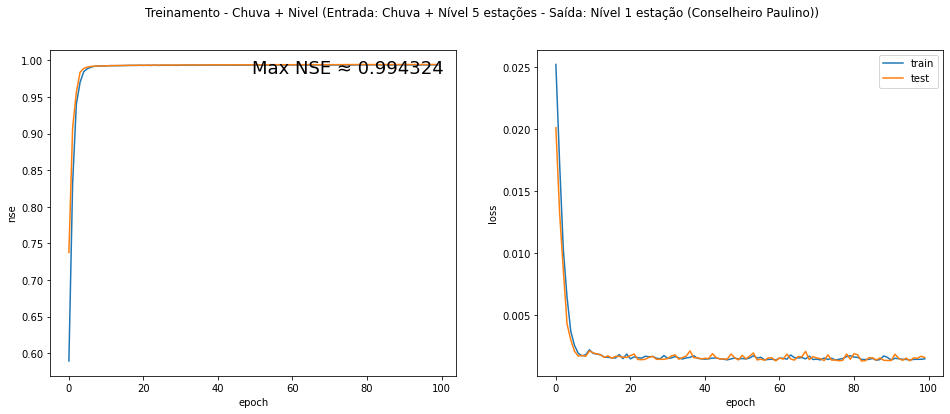

In [7]:
print(get_metrics(history))
plot_history(history, 'Treinamento - Chuva + Nivel (Entrada: Chuva + Nível 5 estações - Saída: Nível 1 estação (Conselheiro Paulino))')


(4991, 10) (4991, 10)
4991


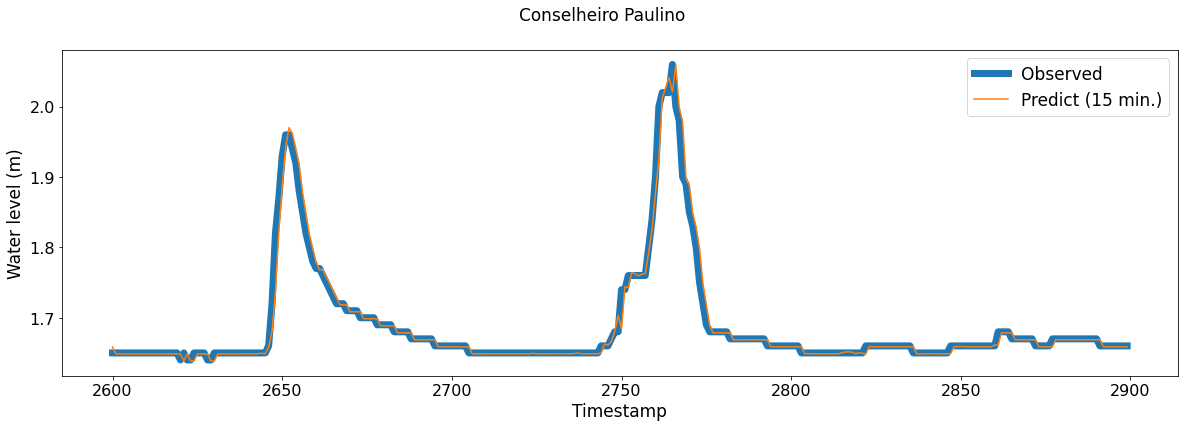

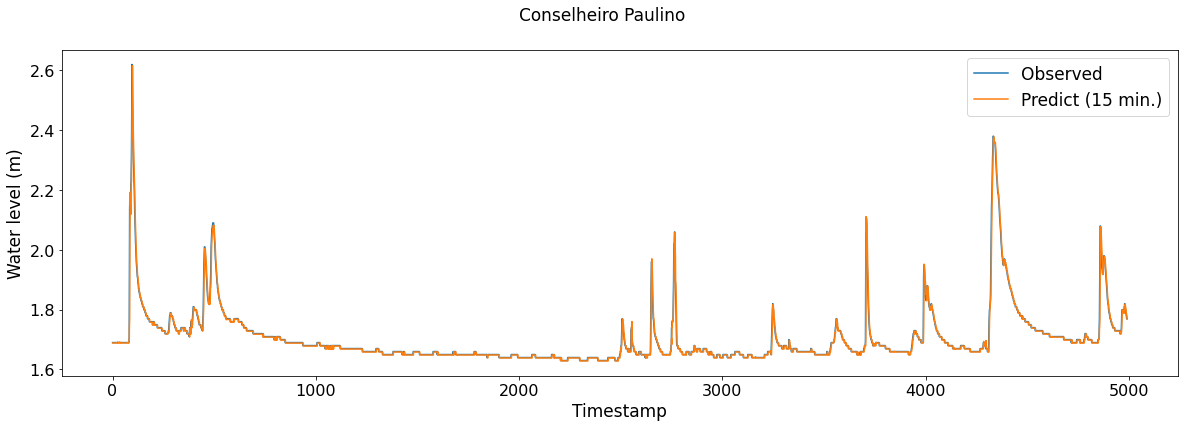

In [8]:
predict_values = model.predict(x_test)

predict_dataset = np.zeros(shape=(len(predict_values), 10))
predict_dataset[:,] = predict_values
predict_dataset = scaler.inverse_transform(predict_dataset)

test_dataset = np.zeros(shape=(len(y_test), 10))
test_dataset[:,9] = y_test
test_dataset = scaler.inverse_transform(test_dataset)

print(predict_dataset.shape, test_dataset.shape)


n_size = 300
total_size = predict_dataset.shape[0]
print(total_size)

start = 2600
fig, (ax1) = plt.subplots(1,1, figsize=(20, 6))
plt.plot(range(start,n_size+start), test_dataset[:,9][start:n_size+start], label='Observed', linewidth=7.0)
plt.plot(range(start,n_size+start), predict_dataset[:,9][start:(n_size+start)], label='Predict ('+ str(i*15) + ' min.)')
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Conselheiro Paulino', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()


fig2, (ax1) = plt.subplots(1,1, figsize=(20, 6))
plt.plot(range(total_size), test_dataset[:,9][:total_size], label='Observed')
plt.plot(range(i,total_size+i), predict_dataset[:,9][:total_size], label='Predict (15 min.)')
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Conselheiro Paulino', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()

